In [1]:
import cobra
import pandas as pd
from util.manipulation import load_latest_model
import numpy as np
import matplotlib.pyplot as plt

### Tutorial 2: Applying modifications

In this tutorial, we will perform modifications to the model and observe the resulting predictions. The list of modifications that we will attempt are listed here:

    1- Modify the objective 
    2- Modify the energy demands
    3- Change the model growth media (i.e.: changing the utilized carbohydrate)

In [2]:
#Load the model
model = load_latest_model()
#Changing the objective
#Get the current model objective
from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction BIOMASS_step3_c at 0x7f17e6e90e48>: 1.0}

In [9]:
for r in model.reactions:
    r.objective_coefficient = 0
    
model.reactions.BIOMASS_step3_c.objective_coefficient = 1.

In [10]:
model.slim_optimize()

0.5936996697548119

In [11]:
#The model currently attemtps to optimise biomass production
#We will try to optimize for the production of ATP
#Conveniently a pseudoreaction exists in the model that simply consummes ATP
model.reactions.ATPM

Reaction identifier,ATPM
Name,ATP maintenance requirement
Memory address,0x07f180cdbeda0
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP + H2O --> ADP + H+ + Phosphate
GPR,
Lower bound,15.306122
Upper bound,1000.0


In [21]:
#We will change the objective to this reaction
#First let's set the linear coefficient to 0 for all reactions in the model
for r in model.reactions:
    r.objective_coefficient = 0.

In [18]:
GAM = model.reactions.BIOMASS_step3_c.get_coefficient('atp_c')

-23.501590379963364

In [19]:
model.reactions.BIOMASS_step3_c.reaction

'0.008561008338781267 CPS_MF_e + 0.005612904471509075 adn_c + 0.501148808488442 alatrna_c + 0.0037552073460267034 amet_c + 0.1096902460381302 argtrna_c + 0.23715094131247275 asntrna_c + 0.21594170394047454 asptrna_c + 23.501590379963364 atp_c + 0.022683040797717182 ca2_c + 0.008235659283549952 cholp_c + 0.025642143375480462 cl_c + 0.015425785619835831 cobalt2_c + 0.1007583798877726 ctp_c + 0.022545630923996075 cystrna_c + 0.0061673416890670844 cytd_c + 0.018116391682073872 datp_c + 0.0072667505781118654 dctp_c + 0.006380562511983434 dgtp_c + 0.01865497185699583 dttp_c + 0.28606920676047565 glutrna_c + 0.5242008009647021 glytrna_c + 0.11656752836197395 gtp_c + 23.501590379963364 h2o_c + 0.04629172165597942 histrna_c + 0.34918208648165194 iletrna_c + 0.023251417813329716 k_c + 0.3325195114579218 leutrna_c + 0.3734549577313136 lystrna_c + 0.08848834435618165 mettrna_c + 0.03740345233865085 mg2_c + 0.0032936337748002663 mlthf_c + 0.016547564495617766 mn2_c + 0.005684034955450808 mobd_c + 0

In [22]:
#Verify that this worked
model.optimize()

,fluxes,reduced_costs
AACPS6,0.22130,0.0
ACKr,-10.20000,-0.0
ACPPAT180,0.11065,0.0
ACPS1,0.00000,0.0
ACPpds,0.00000,0.0
...,...,...
G6PDH2r,0.00000,-0.0
GND,0.00000,0.0
TALA,0.00000,0.0
NOX2,10.30000,0.0


In [23]:
#The model solves with an objective value of 0 because no objective was set (kind of a weird mathematical situation)
#Now set the objective to ATPM and solve again
model.reactions.ATPM.objective_coefficient = 1.
#Force a flux through the biomass reaction
model.reactions.BIOMASS_step3_c.lower_bound = 0.59
#Get the optimal ATP production in M.florum
atp_production = model.optimize()
print(f"The model can produce ATP at an optimal rate of {atp_production.objective_value} mmol/gDW/hr")

The model can produce ATP at an optimal rate of 15.445944014005248 mmol/gDW/hr


In [24]:
#Now load the model again to ensure that all modifications are erased
model = load_latest_model()

In [25]:
print(f"The current non-growth associated maintenance cost is {model.reactions.ATPM.lower_bound} mmol/gDW/hr")

The current non-growth associated maintenance cost is 15.306122 mmol/gDW/hr


In [26]:
#We can work with the model in a contextual way to ensure that modifications do not affect our model object
#to do so we use the with statement. This avoids having to load the model again to erase our modifications and may save a lot
#of computing time.
#Let's use this with statement to modify the model's energy demands
ngam = []
with model:
    for i in range(0,15):
        model.reactions.ATPM.lower_bound = i
        #slim_optimize is faster since it only generates the objective value
        ngam.append(model.slim_optimize())

Text(0.5, 0, 'Non-growth associated maintenance')

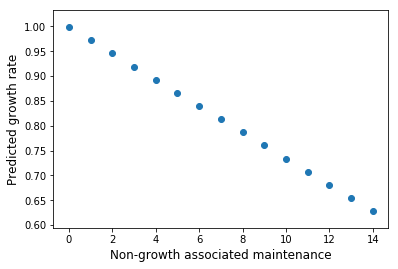

In [27]:
#Plot the growth rate with varying energy demands
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x=range(0,15), y=ngam)
ax.set_ylabel('Predicted growth rate',fontsize=12)
ax.set_xlabel('Non-growth associated maintenance',fontsize=12)

In [28]:
#Let's display the ATPM lower bound to ensure that our with statement worked correctly
#it should be different than 15.0
model.reactions.ATPM.lower_bound

15.306122

In [30]:
#We can change the model medium
#COBRApy provides a function to access the media rapidly
print(f"The model medium contains {len(model.medium)} exchange reactions")

The model medium contains 74 exchange reactions


In [ ]:
for r in model.reactions:
    if r.id.startswith('EX_') and r.lower_bound != 0 and r.upper_bound != 0:
        

In [31]:
model.reactions.EX_ac_e.lower_bound = 0.
model.reactions.EX_ac_e.upper_bound = 0.

Reaction identifier,EX_ac_e
Name,Exchange ac
Memory address,0x07f17e6b21240
Stoichiometry,ac_e --> Acetate -->
GPR,
Lower bound,10.2
Upper bound,20.4


In [32]:
model.reactions.EX_sucr_e

Reaction identifier,EX_sucr_e
Name,Sucrose exchange
Memory address,0x07f17e6b3ce80
Stoichiometry,sucr_e <=> Sucrose <=>
GPR,
Lower bound,-9.0
Upper bound,1000.0


In [33]:
model.reactions.EX_tre_e

Reaction identifier,EX_tre_e
Name,Trehalose exchange
Memory address,0x07f17e6b46240
Stoichiometry,tre_e --> Trehalose -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [34]:
model.reactions.EX_ocdca_e

Reaction identifier,EX_ocdca_e
Name,Octadecanoate (n-C18:0) exchange
Memory address,0x07f17e6b3c4e0
Stoichiometry,ocdca_e <=> Octadecanoate (n-C18:0) <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


In [35]:
#Changing the lower bounds on exchange reactions will effectively change to model medium
#We can use that property to determine the essential components in the media
medium_essentiality = []
for r in model.medium:
    with model:
        exchange_rxn = model.reactions.get_by_id(r)
        exchange_rxn.lower_bound = 0.
        medium_essentiality.append({'Exchange_rxn':exchange_rxn.id, 'Solution':model.slim_optimize()})

In [37]:
#Plot the essentiality of model components
medium_essentiality_df = pd.DataFrame(medium_essentiality)
medium_essentiality_df.sort_values('Solution',inplace=True)
medium_essentiality_df.set_index('Exchange_rxn',inplace=True)

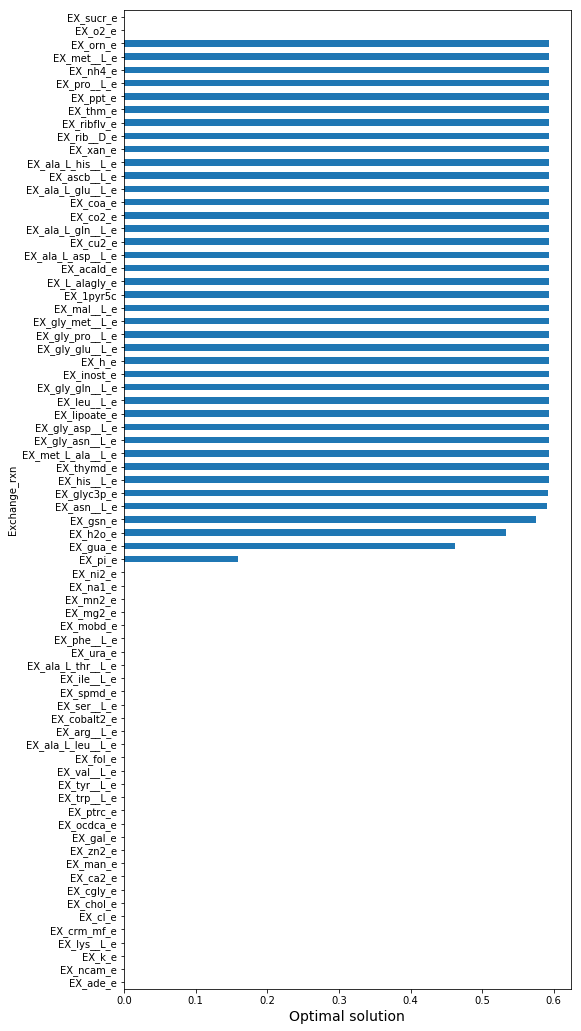

In [38]:
fig = plt.figure(figsize=(8,18))
ax = fig.add_subplot(111)
medium_essentiality_df['Solution'].plot(kind='barh',ax=ax)
ax.set_xlabel('Optimal solution',fontsize=14)
plt.show()

#### End of this tutorial

In this tutorial, dynamic observations were made on the model by modifying some its attributes (energy demands, medium...). Whether or not these predictions are valid is not yet determined as they need to be compared with experimental data. 